In [1]:
%matplotlib inline

import torch.nn as nn
import torch
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data
import numpy as np
import math
from matplotlib import pyplot as plt
from graphviz import Digraph
import os

np.random.seed(0)
torch.manual_seed(0)

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="2,3"

In [2]:
def upsample(x):
    return nn.functional.interpolate(x, scale_factor=2, mode="nearest")

def downsample(x):
    return nn.functional.interpolate(x, scale_factor=0.5, mode="bilinear", align_corners=False)

def conv_layer(in_filters, out_filters=32, kernel_size=3, he_init=True):
    same_padding = (kernel_size-1)//2
    conv = nn.Conv2d(in_filters, out_filters, kernel_size=kernel_size, padding=same_padding)
    
    if he_init:
        he_init_constant = math.sqrt(6 / (in_filters * kernel_size**2))
        nn.init.uniform_(conv.weight, -he_init_constant, he_init_constant)
    else:
        xavier_init_constant = math.sqrt(6 / ((in_filters + out_filters) * kernel_size**2))
        nn.init.uniform_(conv.weight, -xavier_init_constant, xavier_init_constant)
    nn.init.constant_(conv.bias, 0)
    
    return conv

def bn(channels):
    batchnorm = nn.BatchNorm2d(channels, eps=1e-5)
    nn.init.constant_(batchnorm.weight, 1)
    return batchnorm

def linear(in_features, out_features):
    linear_layer = nn.Linear(in_features, out_features)
    
    xavier_init_constant = math.sqrt(6/(in_features+out_features))
    nn.init.uniform_(linear_layer.weight, -xavier_init_constant, xavier_init_constant)
    nn.init.constant_(linear_layer.bias, 0)
    
    return linear_layer

In [5]:
class ResBlock(nn.Module):
    def __init__(self, in_filters, out_filters, resample=None, normalize=False, activation=None):
        super(ResBlock, self).__init__()
        self.in_filters = in_filters
        self.out_filters = out_filters
        self.resample = resample
        self.normalize = normalize
        
        self.conv1 = conv_layer(in_filters, out_filters)
        self.conv2 = conv_layer(out_filters, out_filters)
        
        if resample:
            self.conv3 = conv_layer(in_filters, out_filters, kernel_size=1, he_init=False)
        
        if normalize:
            self.bn1 = bn(in_filters)
            self.bn2 = bn(out_filters)
            
        if activation is not None:
            self.activation = activation
        else:
            self.activation = nn.ReLU()
                
    def forward(self, x): 
        orig_input = x
        
        if self.normalize:
            x = self.bn1(x)
            
        x = self.activation(x)
        
        if self.resample == 'up':
            x = upsample(x)
       
        x = self.conv1(x)

        if self.normalize:
            x = self.bn2(x)
            
        x = self.activation(x)
        x = self.conv2(x)
        
        if self.resample == 'down':
            x = downsample(x)
        
        # Shortcut
        if self.resample == 'down': 
            shortcut_x = downsample(self.conv3(orig_input))
        elif self.resample == 'up':
            shortcut_x = self.conv3(upsample(orig_input))
        elif self.resample == None:
            shortcut_x = orig_input
        
        return x + shortcut_x
    
class SmallResBlock(nn.Module):
    def __init__(self, in_filters, out_filters, activation=None):
        super(SmallResBlock, self).__init__()
        self.in_filters = in_filters
        self.out_filters = out_filters
        
        self.conv1 = conv_layer(in_filters, out_filters)
        self.conv2 = conv_layer(out_filters, out_filters)
        self.conv3 = conv_layer(in_filters, out_filters, kernel_size=1, he_init=False)
            
        if activation is not None:
            self.activation = activation
        else:
            self.activation = nn.ReLU()
                
    def forward(self, x): 
        orig_input = x
       
        x = self.conv1(x)   
        x = downsample(self.conv2(self.activation(x)))

        # Shortcut
        shortcut_x = self.conv3(downsample(orig_input))
        
        return x + shortcut_x 

In [6]:
class Generator(nn.Module):
    def __init__(self, input_size, num_filters=128, num_blocks=3, start_image_size=4, num_channels=3):
        super(Generator, self).__init__()
        
        self.num_filters = num_filters
        self.start_image_size = start_image_size
        
        self.first_linear = linear(input_size, num_filters * start_image_size ** 2)
        self.resblocks = nn.ModuleList()
        self.activation = nn.ReLU()
        
        for _ in range(num_blocks):
            self.resblocks.append(
                ResBlock(in_filters=self.num_filters, 
                         out_filters=self.num_filters, 
                         resample='up', 
                         normalize=True))
            
        self.last_layer = conv_layer(num_filters, num_channels)
        self.bn = bn(num_filters)
        self.manually_initialize()
    
    def forward(self, noise):        
        x = self.first_linear(noise)
        
        x = x.view(-1, self.start_image_size, self.start_image_size, self.num_filters)
        x = x.permute(0, 3, 2, 1) # these last two lines could be simplified but tf consistency forces this.
        
        for resblock in self.resblocks:
            x = resblock(x)
            
        x = self.activation(self.bn(x))
        result = self.last_layer(x)
        return torch.tanh(result)
    
    def manually_initialize(self):
        self.first_linear.weight.data = torch.tensor(np.load("params/generator_dense_kernel:0.npy")).transpose(0,1).contiguous()
        self.first_linear.bias.data = torch.tensor(np.load("params/generator_dense_bias:0.npy"))
        
        self.resblocks[0].bn1.weight.data = torch.tensor(np.load("params/generator_BatchNorm_gamma:0.npy"))
        self.resblocks[0].bn1.bias.data = torch.tensor(np.load("params/generator_BatchNorm_beta:0.npy"))
        
        self.resblocks[0].bn2.weight.data = torch.tensor(np.load("params/generator_BatchNorm_1_gamma:0.npy"))
        self.resblocks[0].bn2.bias.data = torch.tensor(np.load("params/generator_BatchNorm_1_beta:0.npy"))
        
        self.resblocks[1].bn1.weight.data = torch.tensor(np.load("params/generator_BatchNorm_2_gamma:0.npy"))
        self.resblocks[1].bn1.bias.data = torch.tensor(np.load("params/generator_BatchNorm_2_beta:0.npy"))
        
        self.resblocks[1].bn2.weight.data = torch.tensor(np.load("params/generator_BatchNorm_3_gamma:0.npy"))
        self.resblocks[1].bn2.bias.data = torch.tensor(np.load("params/generator_BatchNorm_3_beta:0.npy"))
        
        self.resblocks[2].bn1.weight.data = torch.tensor(np.load("params/generator_BatchNorm_4_gamma:0.npy"))
        self.resblocks[2].bn1.bias.data = torch.tensor(np.load("params/generator_BatchNorm_4_beta:0.npy"))
        
        self.resblocks[2].bn2.weight.data = torch.tensor(np.load("params/generator_BatchNorm_5_gamma:0.npy"))
        self.resblocks[2].bn2.bias.data = torch.tensor(np.load("params/generator_BatchNorm_5_beta:0.npy"))
        
        self.bn.weight.data = torch.tensor(np.load("params/generator_BatchNorm_6_gamma:0.npy"))
        self.bn.bias.data = torch.tensor(np.load("params/generator_BatchNorm_6_beta:0.npy"))
        
        self.resblocks[0].conv1.weight.data = torch.tensor(np.load("params/generator_conv2d_kernel:0.npy")).permute(3,2,1,0).contiguous()
        self.resblocks[0].conv1.bias.data = torch.tensor(np.load("params/generator_conv2d_bias:0.npy"))
        
        self.resblocks[0].conv2.weight.data = torch.tensor(np.load("params/generator_conv2d_1_kernel:0.npy")).permute(3,2,1,0).contiguous()
        self.resblocks[0].conv2.bias.data = torch.tensor(np.load("params/generator_conv2d_1_bias:0.npy"))
        
        self.resblocks[0].conv3.weight.data = torch.tensor(np.load("params/generator_conv2d_2_kernel:0.npy")).permute(3,2,1,0).contiguous()
        self.resblocks[0].conv3.bias.data = torch.tensor(np.load("params/generator_conv2d_2_bias:0.npy"))
        
        self.resblocks[1].conv1.weight.data = torch.tensor(np.load("params/generator_conv2d_3_kernel:0.npy")).permute(3,2,1,0).contiguous()
        self.resblocks[1].conv1.bias.data = torch.tensor(np.load("params/generator_conv2d_3_bias:0.npy"))
        
        self.resblocks[1].conv2.weight.data = torch.tensor(np.load("params/generator_conv2d_4_kernel:0.npy")).permute(3,2,1,0).contiguous()
        self.resblocks[1].conv2.bias.data = torch.tensor(np.load("params/generator_conv2d_4_bias:0.npy"))
        
        self.resblocks[1].conv3.weight.data = torch.tensor(np.load("params/generator_conv2d_5_kernel:0.npy")).permute(3,2,1,0).contiguous()
        self.resblocks[1].conv3.bias.data = torch.tensor(np.load("params/generator_conv2d_5_bias:0.npy"))
        
        self.resblocks[2].conv1.weight.data = torch.tensor(np.load("params/generator_conv2d_6_kernel:0.npy")).permute(3,2,1,0).contiguous()
        self.resblocks[2].conv1.bias.data = torch.tensor(np.load("params/generator_conv2d_6_bias:0.npy"))
        
        self.resblocks[2].conv2.weight.data = torch.tensor(np.load("params/generator_conv2d_7_kernel:0.npy")).permute(3,2,1,0).contiguous()
        self.resblocks[2].conv2.bias.data = torch.tensor(np.load("params/generator_conv2d_7_bias:0.npy"))
        
        self.resblocks[2].conv3.weight.data = torch.tensor(np.load("params/generator_conv2d_8_kernel:0.npy")).permute(3,2,1,0).contiguous()
        self.resblocks[2].conv3.bias.data = torch.tensor(np.load("params/generator_conv2d_8_bias:0.npy"))
        
        self.last_layer.weight.data = torch.tensor(np.load("params/generator_conv2d_9_kernel:0.npy")).permute(3,2,1,0).contiguous()
        self.last_layer.bias.data = torch.tensor(np.load("params/generator_conv2d_9_bias:0.npy"))

In [7]:
class MLPLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLPLayer, self).__init__()
        self.block = nn.Sequential(linear(input_size, output_size), nn.ReLU())
        
    def forward(self, x):
        return self.block(x)

class VectorDiscriminator(nn.Module):
    def __init__(self, input_size, hidden_size, num_blocks):
        super(VectorDiscriminator, self).__init__()
        self.blocks = nn.ModuleList()
        self.blocks.append(MLPLayer(input_size, hidden_size))
        
        for _ in range(num_blocks - 1):
            self.blocks.append(hidden_size, hidden_size)
        
        self.blocks.append(linear(hidden_size, 1))

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        
        return x

In [8]:
class ImageDiscriminator(nn.Module):
    def __init__(self, num_filters=128, num_blocks=4, num_channels=3):
        super(ImageDiscriminator, self).__init__()
        assert num_blocks >= 2, "Number of conv layers in the discriminator must be >= 2."
        
        self.resblocks = nn.ModuleList()
        self.activation = nn.ReLU()
        
        self.resblocks.append(SmallResBlock(in_filters=num_channels, 
                                            out_filters=num_filters))
        self.resblocks.append(ResBlock(in_filters=num_filters, 
                                       out_filters=num_filters, 
                                       resample='down'))
        for _ in range(num_blocks - 2):
            self.resblocks.append(ResBlock(in_filters=num_filters, 
                                           out_filters=num_filters))
            
        self.last_linear = linear(num_filters, 1)
        self.manually_initialize()
   
    def forward(self, x):
        for resblock in self.resblocks:
            x = resblock(x)
            
        x = self.activation(x)
        x = x.mean(dim=(-1,-2))
        x = self.last_linear(x)
        return x
    
    def manually_initialize(self):
        self.last_linear.weight.data = torch.tensor(np.load("params/discriminator_dense_kernel:0.npy")).transpose(0,1).contiguous()
        self.last_linear.bias.data = torch.tensor(np.load("params/discriminator_dense_bias:0.npy"))
        
        self.resblocks[0].conv1.weight.data = torch.tensor(np.load("params/discriminator_conv2d_kernel:0.npy")).permute(3,2,1,0).contiguous()
        self.resblocks[0].conv1.bias.data = torch.tensor(np.load("params/discriminator_conv2d_bias:0.npy"))
        
        self.resblocks[0].conv2.weight.data = torch.tensor(np.load("params/discriminator_conv2d_1_kernel:0.npy")).permute(3,2,1,0).contiguous()
        self.resblocks[0].conv2.bias.data = torch.tensor(np.load("params/discriminator_conv2d_1_bias:0.npy"))
        
        self.resblocks[0].conv3.weight.data = torch.tensor(np.load("params/discriminator_conv2d_2_kernel:0.npy")).permute(3,2,1,0).contiguous()
        self.resblocks[0].conv3.bias.data = torch.tensor(np.load("params/discriminator_conv2d_2_bias:0.npy"))
        
        self.resblocks[1].conv1.weight.data = torch.tensor(np.load("params/discriminator_conv2d_3_kernel:0.npy")).permute(3,2,1,0).contiguous()
        self.resblocks[1].conv1.bias.data = torch.tensor(np.load("params/discriminator_conv2d_3_bias:0.npy"))
        
        self.resblocks[1].conv2.weight.data = torch.tensor(np.load("params/discriminator_conv2d_4_kernel:0.npy")).permute(3,2,1,0).contiguous()
        self.resblocks[1].conv2.bias.data = torch.tensor(np.load("params/discriminator_conv2d_4_bias:0.npy"))
        
        self.resblocks[1].conv3.weight.data = torch.tensor(np.load("params/discriminator_conv2d_5_kernel:0.npy")).permute(3,2,1,0).contiguous()
        self.resblocks[1].conv3.bias.data = torch.tensor(np.load("params/discriminator_conv2d_5_bias:0.npy"))
        
        self.resblocks[2].conv1.weight.data = torch.tensor(np.load("params/discriminator_conv2d_6_kernel:0.npy")).permute(3,2,1,0).contiguous()
        self.resblocks[2].conv1.bias.data = torch.tensor(np.load("params/discriminator_conv2d_6_bias:0.npy"))
        
        self.resblocks[2].conv2.weight.data = torch.tensor(np.load("params/discriminator_conv2d_7_kernel:0.npy")).permute(3,2,1,0).contiguous()
        self.resblocks[2].conv2.bias.data = torch.tensor(np.load("params/discriminator_conv2d_7_bias:0.npy"))
        
        self.resblocks[3].conv1.weight.data = torch.tensor(np.load("params/discriminator_conv2d_8_kernel:0.npy")).permute(3,2,1,0).contiguous()
        self.resblocks[3].conv1.bias.data = torch.tensor(np.load("params/discriminator_conv2d_8_bias:0.npy"))
        
        self.resblocks[3].conv2.weight.data = torch.tensor(np.load("params/discriminator_conv2d_9_kernel:0.npy")).permute(3,2,1,0).contiguous()
        self.resblocks[3].conv2.bias.data = torch.tensor(np.load("params/discriminator_conv2d_9_bias:0.npy"))

In [9]:
def identity_embedding(pic):
    return pic

class WGAN(nn.Module):
    def __init__(self, gamma, noise_size=128, num_filters=128, num_generator_blocks=3, num_discriminator_blocks=4,
                 batch_size=64, num_channels=3, discriminator_epsilon=1e-5, embedding_size=None, 
                 discriminator_hidden_size=None, discriminator_type="Image"):  
        super(WGAN, self).__init__()
        self.generator = Generator(noise_size, num_filters=num_filters, num_blocks=num_generator_blocks,
                                   start_image_size=4, num_channels=num_channels)
        
        if discriminator_type == "Image":
            self.discriminator = ImageDiscriminator(num_filters=num_filters, num_blocks=num_discriminator_blocks, 
                                                    num_channels=num_channels)
        elif discriminator_type == "Vector":
            self.discriminator = VectorDiscriminator(input_size=embedding_size, 
                                                     hidden_size=discriminator_hidden_size,
                                                     num_blocks=num_discriminator_blocks)
        else:
            raise ValueError("Discriminator type not recognized.")
        self.discriminator_epsilon = discriminator_epsilon
        
        # Assumption that the dual space is the same as the original space.
        self.gamma = gamma
        self.lambda_penalty = gamma
        
        self.register_buffer("penalty_grad_outputs", torch.ones(batch_size))
        self.register_buffer("noise_buffer", torch.ones((batch_size, noise_size)))
        self.register_buffer("epsilon_buffer", torch.ones(batch_size, 1, 1, 1))
        
    def forward_train_generator(self, noise=None):
        generated_image = self.forward_predict_generator(noise)
        discriminator_score_generated = self.forward_predict_discriminator(generated_image)
        return self.generator_loss(discriminator_score_generated)
    
    def forward_train_discriminator(self, real_images, noise=None):
        generated_images = self.forward_predict_generator(noise)
        discriminator_score_generated = self.forward_predict_discriminator(generated_images)
        discriminator_score_real = self.forward_predict_discriminator(real_images)
        return self.discriminator_loss(discriminator_score_real, discriminator_score_generated, 
                                       real_images, generated_images)
        
    def forward_predict_generator(self, noise=None):
        if noise is None:
            noise = self.generate_noise()
        return self.generator(noise)
        
    def forward_predict_discriminator(self, images):
        return self.discriminator(images)
    
    def generate_noise(self):
        return torch.randn_like(self.noise_buffer)
    
    def generator_loss(self, d_score_generated):
        return torch.mean(d_score_generated) / self.gamma 
    
    def stable_norm(self, x):
        x = x.view(x.size(0), -1)
        alpha, _ = (x.abs() + 1e-5).max(1)
        
        return alpha * (x/alpha.unsqueeze(1)).norm(p=2, dim=1)
    
    def gradient_penalty(self, real_fake_mix):
        d_score_mix = self.discriminator(real_fake_mix).squeeze(1)
        
        gradients = torch.autograd.grad(d_score_mix, real_fake_mix, grad_outputs=self.penalty_grad_outputs,
                                        create_graph=True)[0]
        gradient_penalty = self.lambda_penalty * torch.mean(self.stable_norm(gradients) / gamma - 1) ** 2
        return gradient_penalty
    
    def discriminator_loss(self, d_score_real, d_score_generated, real_images, generated_images):
        wasserstein_loss = (torch.mean(d_score_generated) - torch.mean(d_score_real)) / self.gamma
        
        epsilon = self.epsilon_buffer.uniform_(0, 1)
        real_fake_mix = epsilon * generated_images + (1 - epsilon) * real_images 
        gradient_penalty = self.gradient_penalty(real_fake_mix)        
        
        d_regularizer_mean = torch.mean(d_score_real ** 2)
        d_loss = -wasserstein_loss +  gradient_penalty + self.discriminator_epsilon * d_regularizer_mean
        return d_loss

In [11]:
class BanachWGAN(nn.Module):
    def __init__(self, gamma, noise_size=128, num_filters=128, num_generator_blocks=3, num_discriminator_blocks=4,
                 batch_size=64, num_channels=3, discriminator_epsilon=1e-5, embedding_func=identity_embedding, 
                 embedding_size=None, discriminator_hidden_size=None, discriminator_type="Image"):  
        super(BanachWGAN, self).__init__(gamma=gamma, noise_size=noise_size, num_filters=num_filters, 
                                         num_generator_blocks=num_generator_blocks, 
                                         num_discriminator_blocks=num_discriminator_blocks, 
                                         batch_size=batch_size, num_channels=num_channels, 
                                         discriminator_epsilon=discriminator_epsilon,
                                         embedding_size=None, discriminator_hidden_size=None, 
                                         discriminator_type="Image")
        
        self.embedding_func = embedding_func
        
        if discriminator_type == "Vector":
            self.noise_buffer.squeeze(-1)
            self.noise_buffer.squeeze(-1)
    
    def forward_train_discriminator(self, real_images, noise=None):
        generated_images = self.forward_predict_generator(noise)
        real_data = self.embedding_func(real_images)
        generated_data = self.embedding_func(generated_images)
        
        discriminator_score_generated = self.discriminator(generated_data)
        discriminator_score_real = self.discriminator(real_data)
        
        return self.discriminator_loss(discriminator_score_real, discriminator_score_generated, 
                                       real_data, generated_data)
        
    def forward_predict_discriminator(self, images):
        return self.discriminator(self.embedding_func(images))

In [12]:
class MetricWGAN(WGAN):
    def __init__(self, gamma, noise_size=128, num_filters=128, num_generator_blocks=3, num_discriminator_blocks=4,
                 batch_size=64, num_channels=3, discriminator_epsilon=1e-5, embedding_func=identity_embedding, 
                 embedding_size=None, discriminator_hidden_size=None, discriminator_type="Image"):  
        super(MetricWGAN, self).__init__(gamma=gamma, noise_size=noise_size, num_filters=num_filters, 
                                         num_generator_blocks=num_generator_blocks, 
                                         num_discriminator_blocks=num_discriminator_blocks, 
                                         batch_size=batch_size, num_channels=num_channels, 
                                         discriminator_epsilon=discriminator_epsilon,
                                         embedding_size=None, discriminator_hidden_size=None, 
                                         discriminator_type="Image")
        self.embedding_func = embedding_func
        
        self.noise_buffer.unsqueeze(1)
        self.noise_buffer.repeat(2, 1, 1, 1, 1).view(2 * batch_size, 1, 1, 1)
        self.batch_size = batch_size
        self.pdist = nn.PairwiseDistance()
    
    def gradient_penalty(self, real_fake_mix):
        sampled_data = self.embedding_func(real_fake_mix) # 2 * batch_size x embedding_size
        sampled_scores = self.discriminator(sampled_data).view(2, self.batch_size) # 2 x batch_size
        sampled_data = sampled_data.view(2, self.batch_size, -1) # 2 x batch_size x embedding_size
        
        num_dist = (sampled_scores[0] - sampled_scores[1]).abs()
        denom_dist = self.pdist(sampled_data[0], sampled_data[1])
        
        return ((num_dist/denom_dist - 1)**2).mean()

In [41]:
# There is one discrepancy in this training code and the bwgan github implementation. That
# version uses an exponential moving average of the weights during evaluation.
#
# One other discrepancy with bwgan is the lack of usage of warm restarts for SGD. That's mentioned in
# the paper but I could not see in the implementation.
#
# The last main discrepancy is related to the model. In the bwgan code gamma is computed each batch. Here
# we compute gamma over the dataset instead. The difference should be very minor as gamma's value across batches
# is pretty stable. For MNIST gamma appeared to range from 29.8-30.1 from looking at a dozen gamma values.
def gan_train(model, dset_loader, optimizers, lr_schedulers, num_updates=1e5,
              use_cuda=False, num_discriminator=5):
    steps_so_far = 0
    curr_epoch = 0
    
    discriminator_optimizer, generator_optimizer = optimizers
    discriminator_lr_scheduler, generator_lr_scheduler = lr_schedulers
    
    display_generator = False
    
    while True:
        print('Epoch {} - Step {}/{}'.format(curr_epoch, steps_so_far, num_updates))
        print('-' * 10)

        # Iterate over data.
        for data, _ in dset_loader:
            if steps_so_far % 1000 == 0:
                print(steps_so_far)
            
            if steps_so_far >= num_updates:
                return model
            
            if use_cuda:
                data = data.cuda()
            
            loss = model.forward_train_discriminator(data)
#             register_hooks(loss)
            
            if steps_so_far % 10 == 4:
                print("Discriminator Loss: ", loss.item())
                display_generator = True
            
            loss.backward()

            discriminator_optimizer.step()
            # zero the parameter gradients
            discriminator_optimizer.zero_grad()
                
                
            if steps_so_far % num_discriminator == num_discriminator-1:
                # This is done because in 1 step the discriminator sees two batches of images
                # while the generator only sees 1.
                loss = (model.forward_train_generator() + model.forward_train_generator())/2
                loss.backward()
                generator_optimizer.step()
                
                # zero the parameter gradients
                generator_optimizer.zero_grad()

                discriminator_lr_scheduler.step()
                generator_lr_scheduler.step()
                if display_generator:
                    print("Generator Loss: ", loss.item())
                    display_generator = False
                    
                    
            if steps_so_far % 500 == 0:
                generated_images = model.forward_predict_generator()
                first_image = generated_images[0, 0].cpu().detach().numpy()
                min_val = float(np.amin(first_image))
                max_val = float(np.amax(first_image))
                plt.title("Generated image, range {} to {}".format(round(min_val, 3), round(max_val, 3)))
                plt.imshow(first_image)
                plt.show()
            
            steps_so_far += 1
        
        curr_epoch += 1

In [14]:
def compute_gamma(dset_loader):
    num_images = len(dset_loader.dataset)
    gamma = 0.0
    
    for data, _ in dset_loader:
        batch_size = data.size()[0]
        gamma += data.cuda().view(batch_size, -1).norm(2, dim=1).sum().item() / num_images
    
    return gamma

In [15]:
def iter_graph(root, callback):
    queue = [root]
    seen = set()
    while queue:
        fn = queue.pop()
        if fn in seen:
            continue
        seen.add(fn)
        for next_fn, _ in fn.next_functions:
            if next_fn is not None:
                queue.append(next_fn)
        callback(fn)

def register_hooks(var):
    def is_bad_grad(grad_output):
        if grad_output is None:
            return False
        
        grad_output = grad_output.data
        return grad_output.ne(grad_output).any() or grad_output.gt(1e4).any()
    
    def hook_cb(fn):
        def register_grad(grad_input, grad_output):
            for grad in grad_output:
                if is_bad_grad(grad):
                    print(fn)
#                     raise ValueError("Hi")
        fn.register_hook(register_grad)
    iter_graph(var.grad_fn, hook_cb)

In [24]:
noise_size = 128
batch_size = 1
use_cuda = True
base_lr = 2e-4
num_updates = int(1e2)
num_discriminator = 5
num_channels = 3

In [17]:
def get_data(name, train=True):
    assert name in ["mnist", "cifar", "celeba"]
    transform = transforms.Compose([transforms.Resize(32),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])
    if name == "mnist":
        return datasets.MNIST("mnist", train=train, download=True, transform=transform)
    if name == "cifar":
        return datasets.CIFAR10("cifar", train=train, transform=transform, download=True)
    if name == "celeba":
        if train == True:
            dset_str = "train"
        else:
            dset_str = "test"
        with open("celeba_64_bgr_-1_to_1_%s.pkl" % dset_str, "rb") as f:
            dataset = pickle.load(f)
        return dataset

In [26]:
train_dataset = get_data("cifar")
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                                   num_workers=4, pin_memory=True, drop_last=True)
gamma = compute_gamma(train_dataloader)

Files already downloaded and verified


Epoch 0 - Step 0/100
----------
0


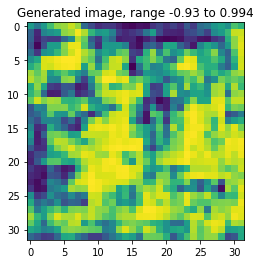

Discriminator Loss:  24.17747688293457
Generator Loss:  1.4177587032318115
Discriminator Loss:  283.9795837402344
Generator Loss:  251.44830322265625
Discriminator Loss:  33811.546875
Generator Loss:  4903.61328125
Discriminator Loss:  18311068.0
Generator Loss:  48326.1953125
Discriminator Loss:  2849058048.0
Generator Loss:  394881.375
Discriminator Loss:  5204018688.0
Generator Loss:  1922231.5
Discriminator Loss:  332722896896.0
Generator Loss:  8115658.5
Discriminator Loss:  -10302812.0
Generator Loss:  10590965.0
Discriminator Loss:  -12703802.0
Generator Loss:  13210098.0
Discriminator Loss:  3916660998144.0
Generator Loss:  19363862.0
3.806027412414551


In [40]:
model = WGAN(gamma=gamma, noise_size=noise_size, batch_size=batch_size, num_channels=num_channels)
# model.train()
# y = torch.ones(1,128)
# output1 = model.forward_predict_generator(y)
# # z = torch.ones(1, 3, 32, 32)
# # output2 = model.forward_predict_discriminator(z)

# print(output1)
# print(output1.size())

# print(output2)

if use_cuda:
    model = model.cuda()
    model.discriminator = nn.DataParallel(model.discriminator)
    model.generator = nn.DataParallel(model.generator)

discriminator_optimizer = optim.Adam(model.discriminator.parameters(), betas=(0, 0.9), lr=base_lr)
generator_optimizer = optim.Adam(model.generator.parameters(), betas=(0, 0.9), lr=base_lr)
discriminator_lr_scheduler = optim.lr_scheduler.LambdaLR(discriminator_optimizer, lambda step: max(0, (1 - step/num_updates)))
generator_lr_scheduler = optim.lr_scheduler.LambdaLR(generator_optimizer, lambda step: max(0, (1 - step/num_updates)))
optimizers = discriminator_optimizer, generator_optimizer
lr_schedulers = discriminator_lr_scheduler, generator_lr_scheduler

import time

start_time = time.time()
model.train()
model = gan_train(model, train_dataloader, optimizers, lr_schedulers, num_updates=num_updates, 
                  use_cuda=use_cuda, num_discriminator=num_discriminator)
print(time.time() - start_time)